In [12]:
import numpy as np
import pandas as pd
import datetime 
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.graphics.gofplots import qqplot_2samples
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from sklearn.preprocessing import MinMaxScaler
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, LSTM
from pyts.decomposition import SingularSpectrumAnalysis
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

C:\Users\steba\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.5 is exactly one major version older than the runtime version 6.31.1 at google/protobuf/any.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

C:\Users\steba\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.5 is exactly one major version older than the runtime version 6.31.1 at google/protobuf/wrappers.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
# Cargamos el archivo CSV que contiene los datos históricos del índice S&P 500.
# Especificamos la ruta completa del archivo en el sistema local.
datos_SyP500 = pd.read_csv('C:/Users/fperilla/OneDrive - Athletic Sport Inc SAS/Escritorio/Proyecto Entrega 2/SP500.csv')


# Convertimos la columna 'SP500' a formato numérico.
# Si hay errores en la conversión (por ejemplo, texto no numérico), se reemplazan con NaN.
datos_SyP500['SP500'] = pd.to_numeric(datos_SyP500['SP500'], errors='coerce')

# Convertimos la columna 'FECHA' a formato de fecha y hora (datetime).
# Esto es útil para análisis de series temporales.
datos_SyP500['DATE'] = pd.to_datetime(datos_SyP500['DATE']).dt.date

datos_SyP500.dropna(inplace=True)

# Establecemos la columna 'FECHA' como índice del DataFrame.
# Esto facilita operaciones como resampling o selección por fecha.
datos_SyP500.set_index('DATE', inplace=True)
datos_SyP500.rename(columns={'DATE': 'FECHA'}, inplace=True)

# Mostramos las primeras 10 filas del DataFrame para obtener una vista previa de los datos.
datos_SyP500.head(10)


,SP500
DATE,
2010-06-28,1074.57
2010-06-29,1041.24
2010-06-30,1030.71
2010-07-01,1027.37
2010-07-02,1022.58
2010-07-06,1028.06
2010-07-07,1060.27
2010-07-08,1070.25
2010-07-09,1077.96


In [ ]:
# Filtrar los datos del S&P 500 para quedarnos con un subconjunto mayor a 1 de enero de 2015.
datos_periodo_seleccionado = datos_SyP500[
    (datos_SyP500.index > datetime.date(2015, 1, 1))
]

# Análisis Exploratorio de Datos

In [ ]:
datos_periodo_seleccionado.head(10)

,SP500
DATE,
2015-01-02,2058.20
2015-01-05,2020.58
2015-01-06,2002.61
2015-01-07,2025.90
2015-01-08,2062.14
2015-01-09,2044.81
2015-01-12,2028.26
2015-01-13,2023.03
2015-01-14,2011.27


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'S&P 500')]

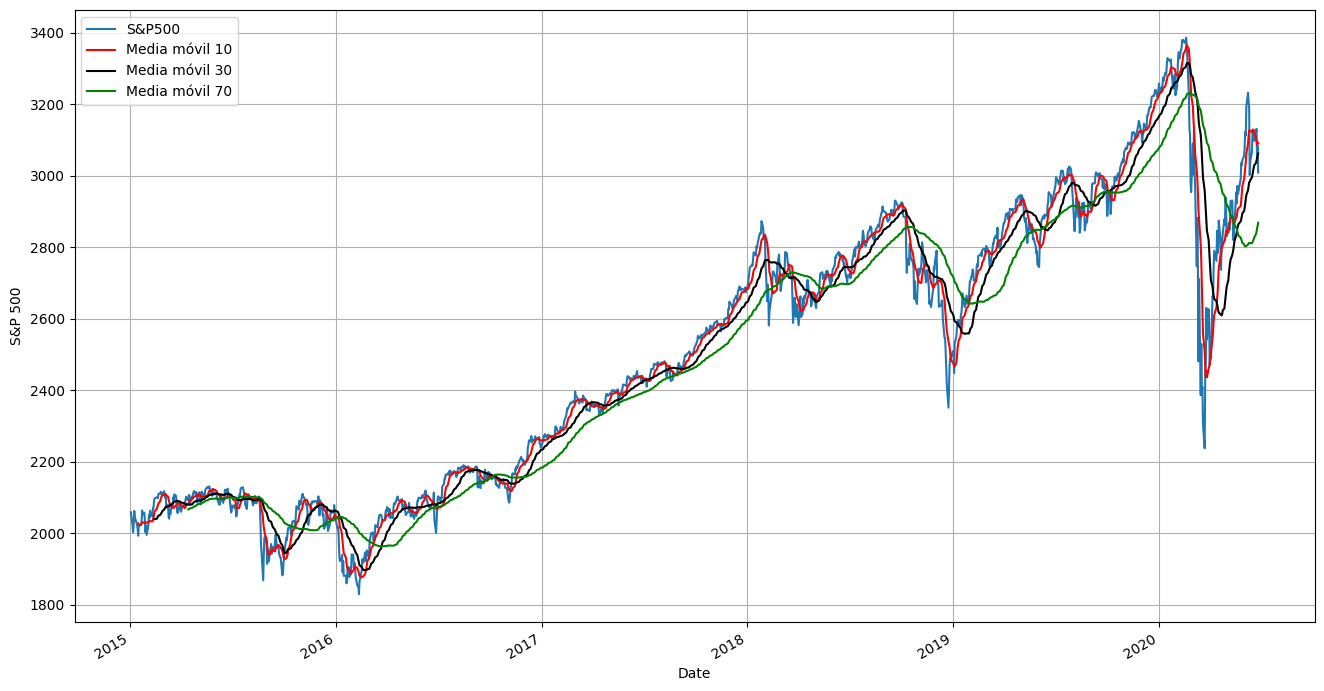

In [ ]:
# Calcula la media móvil de 10 días sobre la columna 'SP500' del DataFrame.
media_movil_10 = datos_periodo_seleccionado.SP500.rolling(window=10).mean()

# Calcula la media móvil de 30 días.
media_movil_30 = datos_periodo_seleccionado.SP500.rolling(window=30).mean()

# Calcula la media móvil de 70 días.
media_movil_70 = datos_periodo_seleccionado.SP500.rolling(window=70).mean()


# Crea una figura y ejes para graficar, con un tamaño personalizado (16x9 pulgadas).
fig, ax = plt.subplots(figsize=(16, 9))
fig.autofmt_xdate()
ax.plot(datos_periodo_seleccionado.SP500, label='S&P500', color='tab:blue')
ax.plot(media_movil_10, label='Media móvil 10', color='r')
ax.plot(media_movil_30, label='Media móvil 30', color='k')
ax.plot(media_movil_70, label='Media móvil 70', color='g')
ax.legend()
ax.grid()
ax.set(xlabel='Date',ylabel='S&P 500')

In [ ]:
# Define una función para comprobar la estacionariedad de una serie temporal
def revisar_estacionalidad(timeseries):
    # Ejecuta la prueba ADF sobre la serie temporal con selección automática de rezagos basada en AIC
    result = adfuller(timeseries, autolag='AIC')
    
    # Organiza los resultados principales en una serie de pandas para referencia
    dfoutput = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    # Imprime el estadístico de prueba
    print('The test statistic: %f' % result[0])
    
    # Imprime el valor p asociado
    print('p-value: %f' % result[1])
    
    # Imprime los valores críticos para los diferentes niveles de significancia
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

# Aplica la función a la serie SP500 del subconjunto df_sample
revisar_estacionalidad(datos_periodo_seleccionado.SP500)


The test statistic: -1.508554
p-value: 0.529276
Critical Values:
1%: -3.435
5%: -2.864
10%: -2.568


In [ ]:
revisar_estacionalidad(datos_periodo_seleccionado.SP500)

The test statistic: -1.508554
p-value: 0.529276
Critical Values:
1%: -3.435
5%: -2.864
10%: -2.568


C:\Users\fperilla\AppData\Local\Temp\ipykernel_15268\2193472543.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = dataset[i] - dataset[i - interval]


<Axes: >

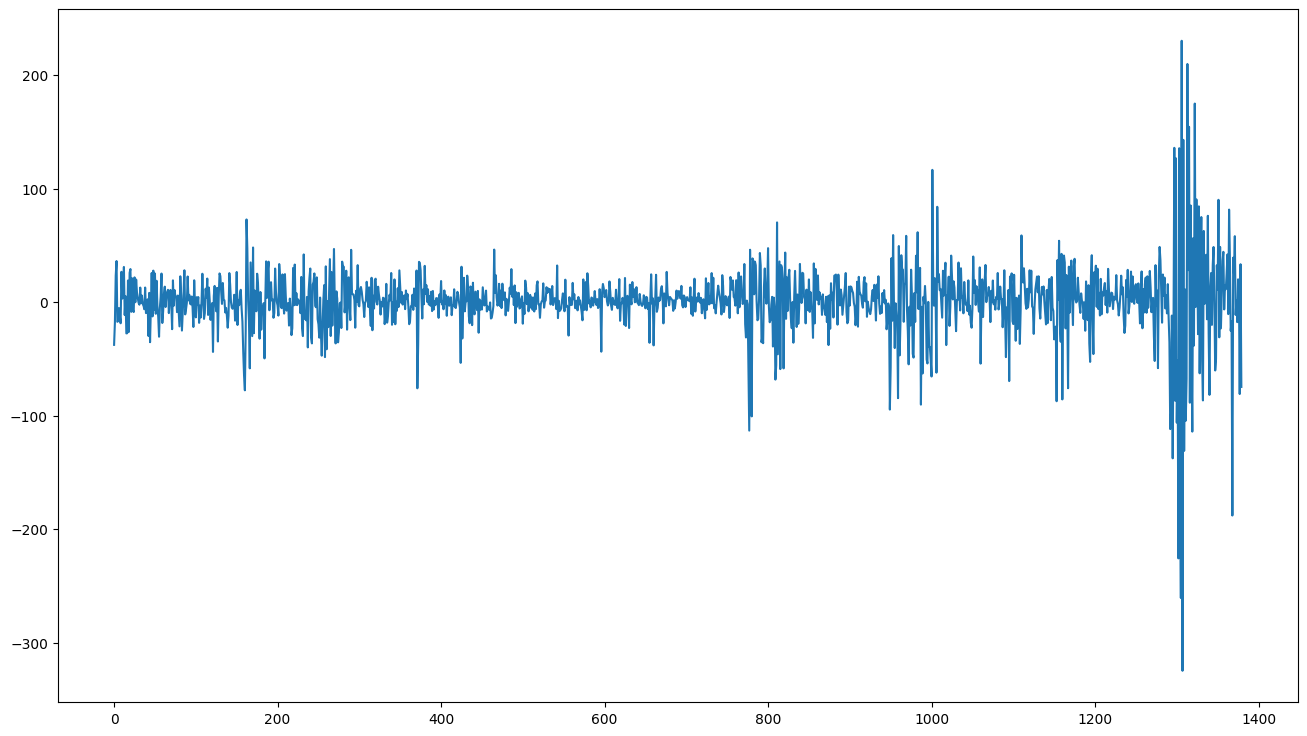

In [ ]:
# Define una función para aplicar la diferenciación a una serie temporal
# La diferenciación se utiliza para hacer que una serie no estacionaria se vuelva estacionaria
def difference(dataset, interval=1):
    diff = list()  # Lista para almacenar los valores diferenciados
    
    # Recorre la serie desde el índice igual al intervalo hasta el final
    for i in range(interval, len(dataset)):
        # Calcula la diferencia entre el valor actual y el valor 'interval' posiciones atrás
        value = dataset[i] - dataset[i - interval]
        diff.append(value)  # Agrega el resultado a la lista

    # Devuelve la lista como una Serie de pandas
    return pd.Series(diff)

# Aplica la función de diferenciación a la serie SP500 con un intervalo de 1 (diferencia de primer orden)
df_diff = difference(datos_periodo_seleccionado.SP500, 1)

# Grafica la serie diferenciada con un tamaño de figura de 16x9 pulgadas
df_diff.plot(figsize=(16, 9))


,SP500,y_log
DATE,,
2015-01-02,2058.20,7.629587
2015-01-05,2020.58,7.611140
2015-01-06,2002.61,7.602207
2015-01-07,2025.90,7.613769
2015-01-08,2062.14,7.631500


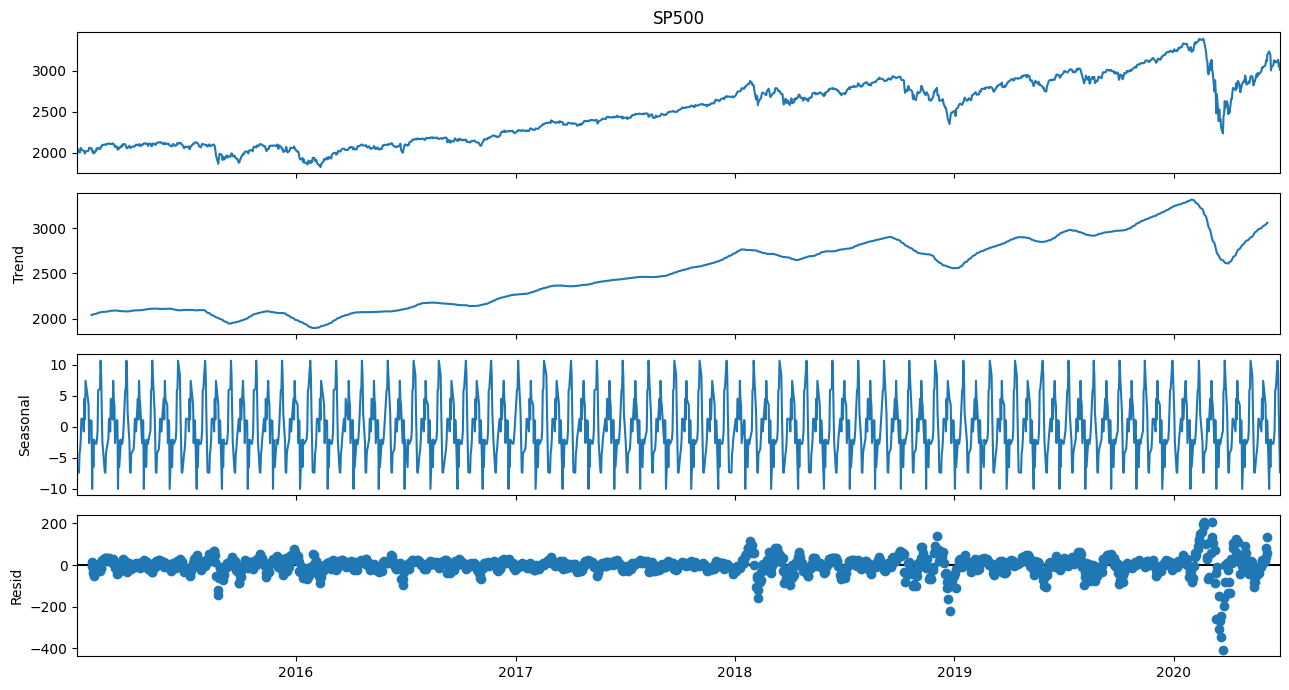

In [ ]:
# Aplica la descomposición estacional aditiva a la serie 'SP500' con un período de 30 dias
decomposition = seasonal_decompose(datos_periodo_seleccionado['SP500'], model='additive', period=30)

# Establece el tamaño de las figuras para los gráficos de matplotlib
plt.rcParams["figure.figsize"] = [13, 7]

# Grafica los componentes de la descomposición: tendencia, estacionalidad y residuo
fig = decomposition.plot()

# Agrega una nueva columna al DataFrame datos_periodo_seleccionado que contiene el logaritmo natural de la serie 'SP500'
datos_periodo_seleccionado = datos_periodo_seleccionado.assign(y_log=np.log(datos_periodo_seleccionado.SP500))

# Muestra las primeras filas del DataFrame actualizado
datos_periodo_seleccionado.head()


# ARIMA

In [ ]:
# Define la lista de posibles valores para el parámetro p (autoregresivo)
#p = [0, 1, 2, 4, 6, 8, 10]

# Define los rangos de valores para los parámetros d (diferenciación) y q (promedio móvil)
#d = range(0, 3)
#q = range(0, 3)

# Genera todas las combinaciones posibles de parámetros (p, d, q) usando producto cartesiano
#pdq = list(itertools.product(p, d, q))

# Itera sobre cada combinación de parámetros para evaluar distintos modelos ARIMA
#for param in pdq:
    #try:
        # Crea un modelo ARIMA con la combinación actual de parámetros
        #model = ARIMA(df_datos_periodo_seleccionado.y_log, order=param)
        
        # Ajusta el modelo a los datos
        #results = model.fit()
        
        # Imprime la combinación de parámetros y el valor del AIC (criterio de información de Akaike)
        #print('ARIMA{} - AIC:{}'.format(param, results.aic))
    
    # Si ocurre un error en alguna combinación, continúa con la siguiente sin interrumpir el ciclo
    #except:
        #continue  


In [ ]:
# Código para inicializar el modelo
modelo = ARIMA(datos_periodo_seleccionado.y_log, order=(8,0, 2))

# Ajustar el modelo sin el argumento 'disp'
modelo_ajustado = modelo.fit()

# Imprimir el resumen del modelo
print(modelo_ajustado.summary())

C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

                               SARIMAX Results                                
Dep. Variable:                  y_log   No. Observations:                 1381
Model:                 ARIMA(8, 0, 2)   Log Likelihood                4252.146
Date:                Fri, 18 Jul 2025   AIC                          -8480.293
Time:                        15:56:51   BIC                          -8417.526
Sample:                             0   HQIC                         -8456.813
                               - 1381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8170      0.084     93.420      0.000       7.653       7.981
ar.L1          0.4869      0.133      3.664      0.000       0.226       0.747
ar.L2          0.6835      0.041     16.613      0.0

[]

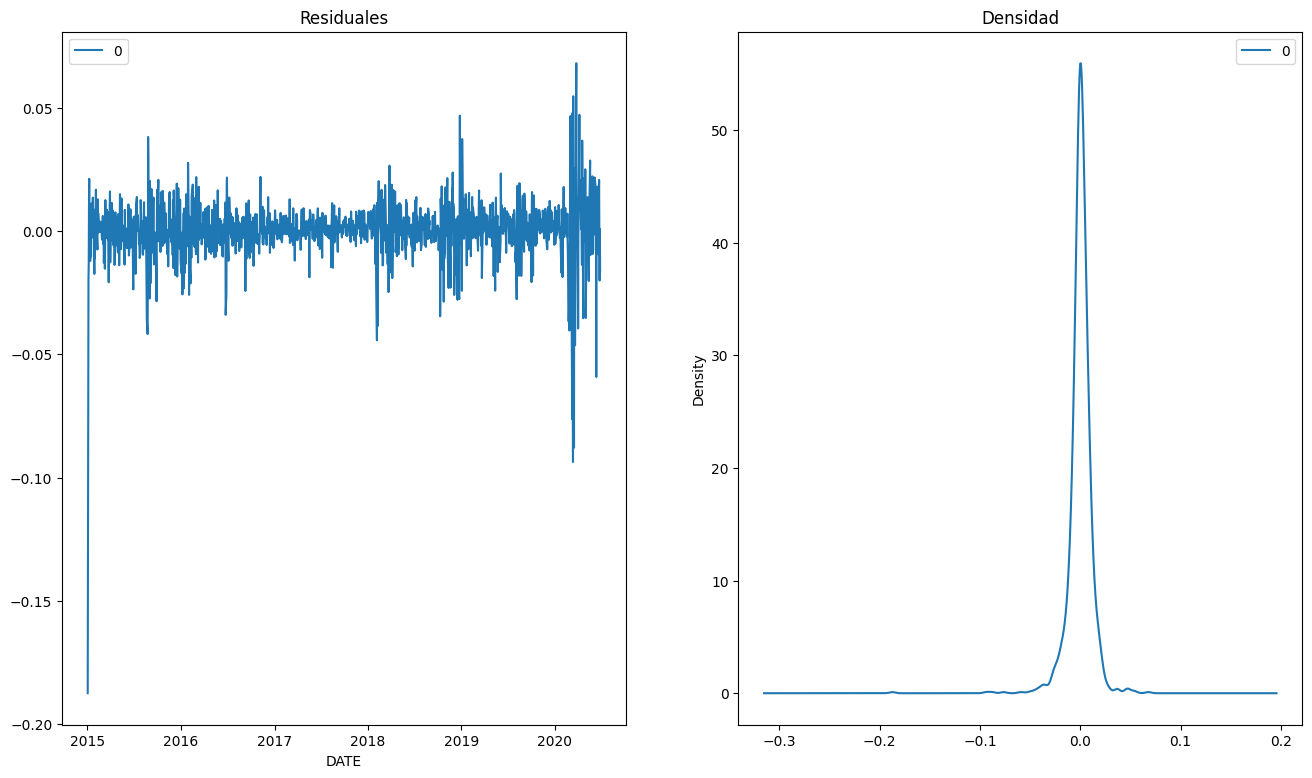

In [ ]:
# Crea un DataFrame con los residuales del modelo ajustado (diferencia entre valores observados y predichos)
Residuales = pd.DataFrame(modelo_ajustado.resid)

# Crea una figura con dos subgráficos en una fila, tamaño 16x9 pulgadas
fig, ax = plt.subplots(1, 2, figsize=(16, 9))

# Grafica los residuales como serie temporal en el primer subgráfico
Residuales.plot(title="Residuales", ax=ax[0])

# Grafica la densidad (distribución) de los residuales en el segundo subgráfico
Residuales.plot(kind='kde', title='Densidad', ax=ax[1])

# Muestra todos los gráficos generados
plt.plot()

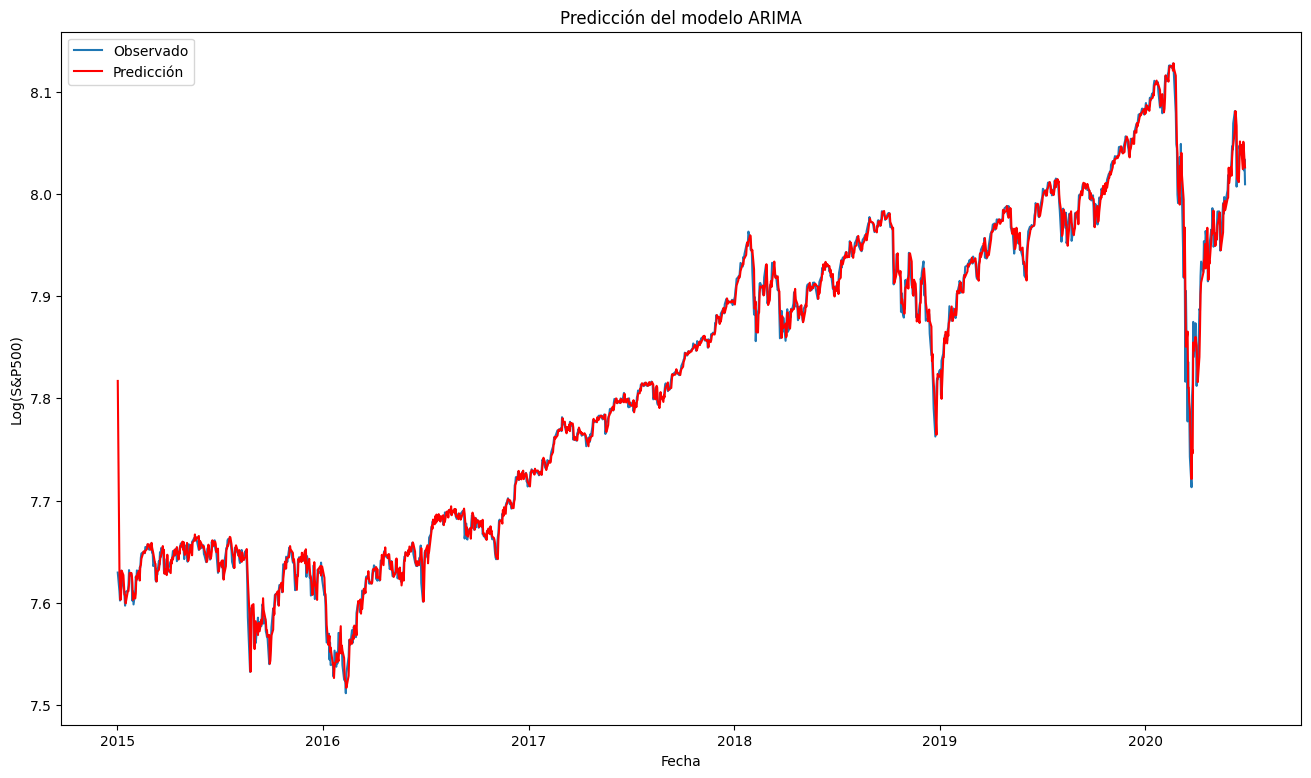

In [ ]:
# Define las dimensiones deseadas de la figura (ancho = 16, alto = 9)
n, m = 16, 9

# Usa un contexto temporal para aplicar configuraciones gráficas
with plt.rc_context():
    # Establece el tamaño de la figura dentro del contexto de matplotlib
    plt.rc("figure", figsize=(n, m))
    
    # Genera las predicciones del modelo sobre todo el conjunto de datos
    pred = modelo_ajustado.get_prediction(dynamic=False)
    
    # Extrae los valores ajustados (fitted) y su índice temporal
    pred_mean = pred.predicted_mean
    pred_index = pred_mean.index

    # Grafica la serie original junto con las predicciones del modelo
    plt.plot(datos_periodo_seleccionado.index, datos_periodo_seleccionado.y_log, label='Observado')
    plt.plot(pred_index, pred_mean, label='Predicción', color='red')
    plt.legend()
    plt.title('Predicción del modelo ARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Log(S&P500)')


C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

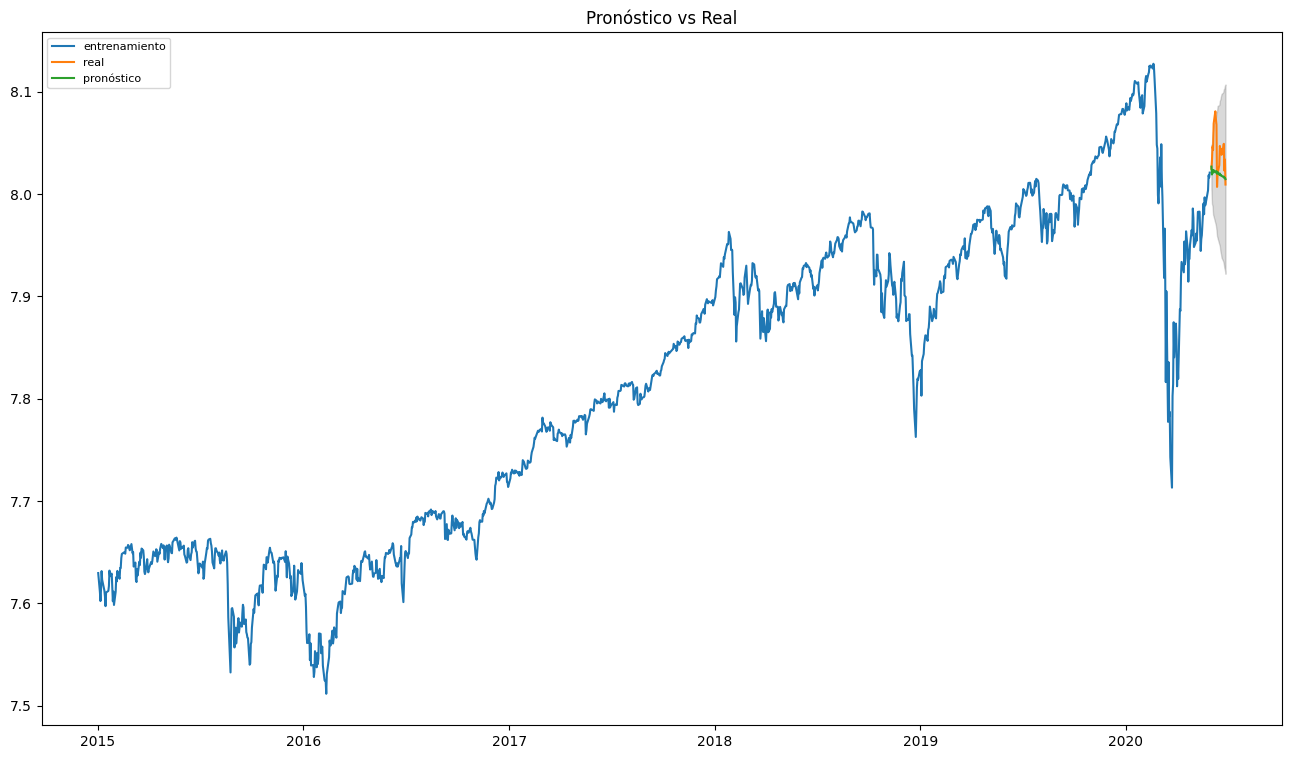

In [ ]:
# Índice que marca el final del conjunto de entrenamiento
INDICE_FIN_ENTRENAMIENTO = 1361

# Tupla con los mejores parámetros ARIMA seleccionados previamente (p, d, q)
orden_seleccionado = (8, 0, 2)

# Crear el conjunto de entrenamiento con los primeros 1361 registros (log-transformación de SP500)
entrenamiento = datos_periodo_seleccionado.y_log[:INDICE_FIN_ENTRENAMIENTO]

# Crear el conjunto de prueba con los datos restantes
prueba = datos_periodo_seleccionado.y_log[INDICE_FIN_ENTRENAMIENTO:]

# Construir el modelo ARIMA con los parámetros seleccionados
modelo = ARIMA(entrenamiento, order=orden_seleccionado)

# Ajustar el modelo a los datos de entrenamiento
modelo_ajustado = modelo.fit()

# Realizar un pronóstico de 20 pasos hacia adelante con intervalo de confianza del 95%
resultado_forecast = modelo_ajustado.get_forecast(steps=20)

# Obtener la serie de valores pronosticados
pronostico = resultado_forecast.predicted_mean

# Obtener los intervalos de confianza
intervalo_confianza = resultado_forecast.conf_int(alpha=0.05)

# Crear una serie con los valores pronosticados, usando el mismo índice temporal del conjunto de prueba
serie_pronostico = pd.Series(pronostico.values, index=prueba.index[:20])

# Crear series para los límites inferior y superior del intervalo de confianza
serie_inferior = pd.Series(intervalo_confianza.iloc[:, 0].values, index=prueba.index[:20])
serie_superior = pd.Series(intervalo_confianza.iloc[:, 1].values, index=prueba.index[:20])

# Graficar los datos de entrenamiento, prueba, pronóstico e intervalos de confianza
plt.figure(figsize=(16, 9))
plt.plot(entrenamiento, label='entrenamiento')           # Datos históricos usados para entrenar
plt.plot(prueba, label='real')                           # Datos reales futuros (prueba)
plt.plot(serie_pronostico, label='pronóstico')           # Pronóstico del modelo ARIMA
plt.fill_between(serie_inferior.index, serie_inferior, serie_superior, 
                 color='k', alpha=.15)                   # Relleno del intervalo de confianza
plt.title('Pronóstico vs Real')                          # Título del gráfico
plt.legend(loc='upper left', fontsize=8)                 # Leyenda en la parte superior izquierda




(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x2c705d1e720>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x2c705d0dbb0>)

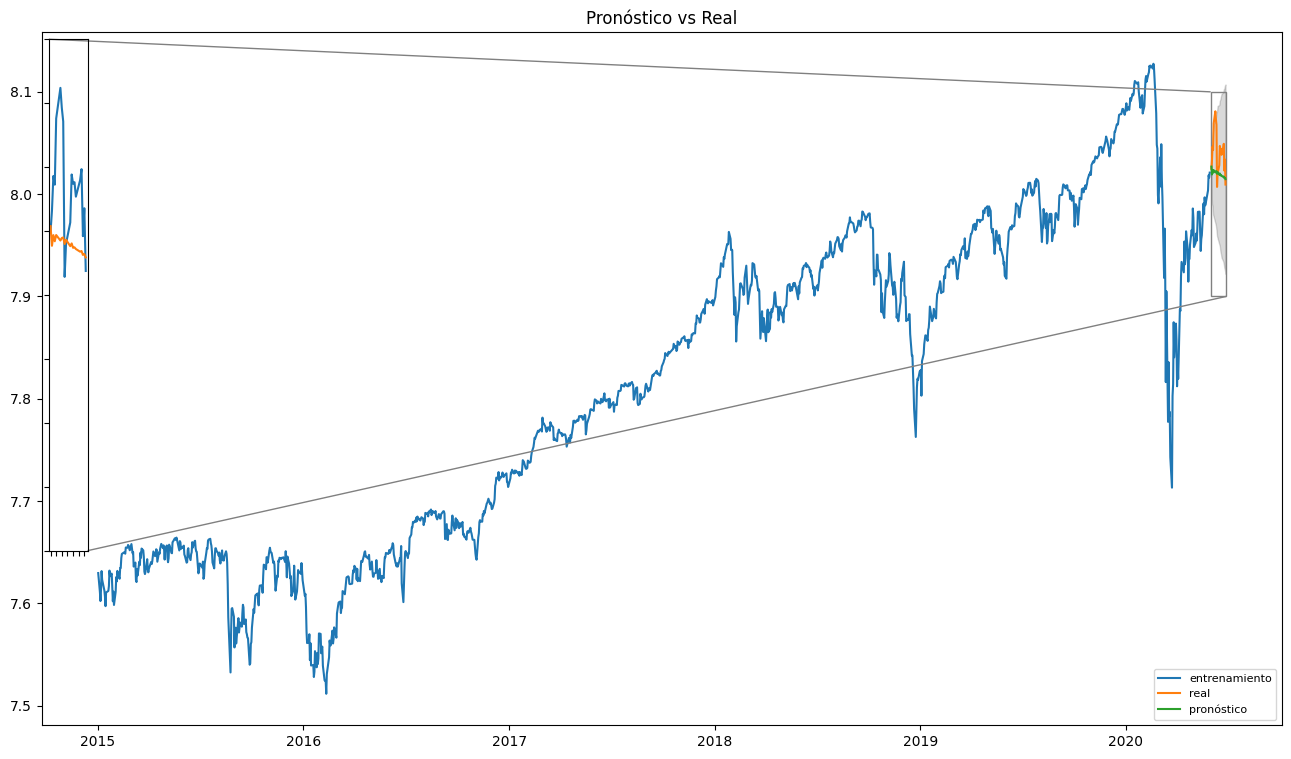

In [ ]:
# Crea una figura y un eje principal con tamaño 16x9
fig, ax = plt.subplots(figsize=(16, 9))

# Grafica los datos de entrenamiento
ax.plot(entrenamiento, label='entrenamiento')

# Grafica los datos reales (conjunto de prueba)
ax.plot(prueba, label='real')

# Grafica la serie pronosticada
ax.plot(serie_pronostico, label='pronóstico')

# Agrega el intervalo de confianza alrededor del pronóstico
ax.fill_between(serie_inferior.index, serie_inferior, serie_superior, 
                color='k', alpha=.15)

# Establece el título del gráfico principal
ax.set_title('Pronóstico vs Real')

# Muestra la leyenda en la parte inferior derecha
ax.legend(loc='lower right', fontsize=8)

# Crea un eje interno con zoom (factor de zoom = 2.5, ubicación = esquina superior izquierda)
axins = zoomed_inset_axes(ax, 2.5, loc=2)

# Grafica los datos reales en el gráfico con zoom
axins.plot(prueba)

# Grafica la serie pronosticada en el gráfico con zoom
axins.plot(serie_pronostico)

# Define los límites de visualización para el eje x e y en la zona ampliada
x1, x2, y1, y2 = '2020-05-01', '2020-06-26', 7.9, 8.1  # Límites del zoom

# Aplica solo los límites en el eje y (se puede agregar x si es necesario)
axins.set_ylim(y1, y2)

# Oculta las etiquetas del eje y en el gráfico de zoom
plt.yticks(visible=False)

# Oculta las etiquetas del eje x en el gráfico de zoom
plt.xticks(visible=False)

# Dibuja líneas que conectan el gráfico principal con el gráfico con zoom
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


In [ ]:
# Función para calcular el error porcentual absoluto medio (MAPE)
def error_porcentual_absoluto_medio(y_real, y_predicho): 
    y_real, y_predicho = np.array(y_real), np.array(y_predicho)
    return np.mean(np.abs((y_real - y_predicho) / y_real)) * 100

# Importa métricas de error desde scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcula el error cuadrático medio (MSE) entre los valores reales y pronosticados (retransformados con exponencial)
print('Error cuadrático medio del modelo ARIMA:', mean_squared_error(np.exp(prueba), np.exp(serie_pronostico)))

# Calcula el error absoluto medio (MAE)
print('Error absoluto medio del modelo ARIMA:', mean_absolute_error(np.exp(prueba), np.exp(serie_pronostico)))

# Calcula el error porcentual absoluto medio (MAPE)
print('Error porcentual absoluto medio del modelo ARIMA:', error_porcentual_absoluto_medio(np.exp(prueba), np.exp(serie_pronostico)))


Error cuadrático medio del modelo ARIMA: 7915.169569902505
Error absoluto medio del modelo ARIMA: 73.44867694629542
Error porcentual absoluto medio del modelo ARIMA: 2.334454126543196


### SARIMAX

In [ ]:
# Define los rangos para los parámetros p, d y q del modelo SARIMA (valores entre 0 y 1)
#p = d = q = range(0, 2)

# Genera todas las combinaciones posibles de (p, d, q) para el componente no estacional
#pdq = list(itertools.product(p, d, q))

# Genera todas las combinaciones posibles de (p, d, q, 12) para el componente estacional (frecuencia = 12)
#ordenes_estacionales = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

# Importa la clase SARIMAX desde statsmodels para construir modelos SARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Bucle anidado para evaluar todas las combinaciones de parámetros estacionales y no estacionales
#for orden in pdq:
    #for orden_estacional in ordenes_estacionales:
        #try:
            # Construye el modelo SARIMA con la combinación actual de parámetros
            #modelo = SARIMAX(datos_periodo_seleccionado.y_log,
                             #order=orden,
                             #seasonal_order=orden_estacional,
                             #enforce_stationarity=False,      # No fuerza la estacionariedad
                             #enforce_invertibility=False)     # No fuerza la invertibilidad
            
            # Ajusta el modelo a los datos
            #resultados = modelo.fit()
            
            # Imprime la combinación de parámetros junto con el valor del AIC
            #print('ARIMA{}x{}12 - AIC:{}'.format(orden, orden_estacional, resultados.aic))
        
        # Si alguna combinación genera error, continúa con la siguiente sin detener el proceso
        #except:
            #continue


In [ ]:
# Ajustar un modelo SARIMA a la serie transformada (logaritmo de SP500)
modelo_sarima = SARIMAX(datos_periodo_seleccionado.y_log,
                        order=(1, 0, 1),                 # Parámetros no estacionales: (p=1, d=0, q=1)
                        seasonal_order=(0, 0, 0, 12),     # Parámetros estacionales: (P=0, D=0, Q=0, s=12)
                        enforce_stationarity=False,      # No se fuerza la estacionariedad del modelo
                        enforce_invertibility=False)     # No se fuerza la invertibilidad del modelo

# Ajusta el modelo a los datos
resultados_sarima = modelo_sarima.fit()

# Imprime la tabla con los coeficientes estimados del modelo
print(resultados_sarima.summary().tables[1])


NameError: name 'SARIMAX' is not defined

[]

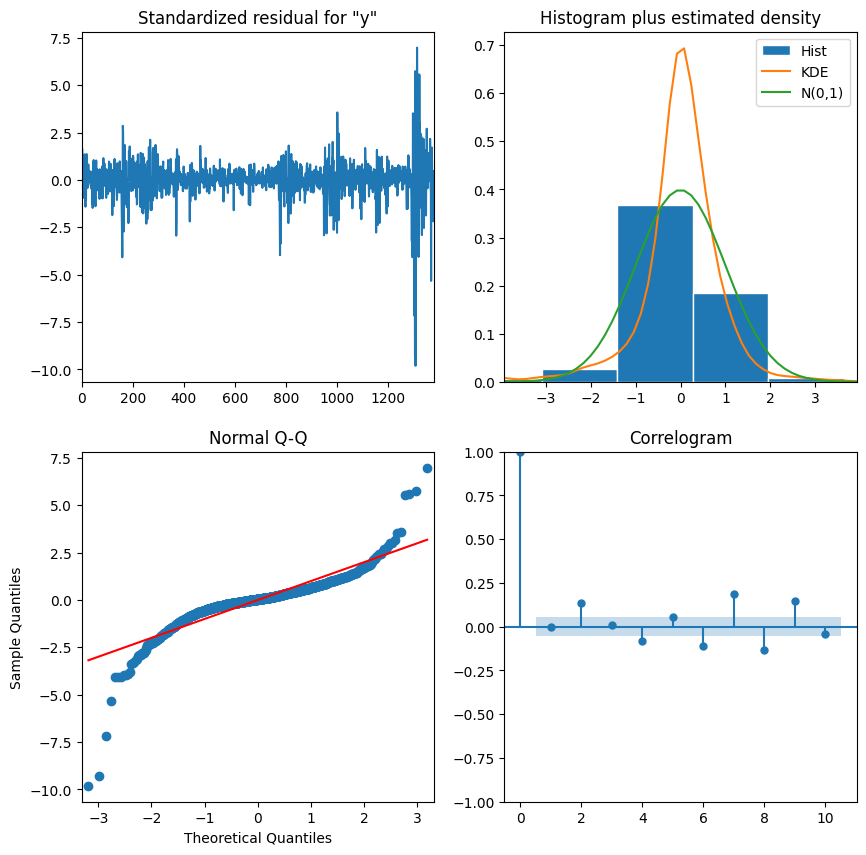

In [ ]:
# Generar los gráficos de diagnóstico del modelo SARIMA ajustado
# Incluye: residuos estandarizados, histograma, QQ-plot y autocorrelación de residuos
resultados_sarima.plot_diagnostics(figsize=(10, 10))

# Mostrar la figura generada por matplotlib
plt.plot()


C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

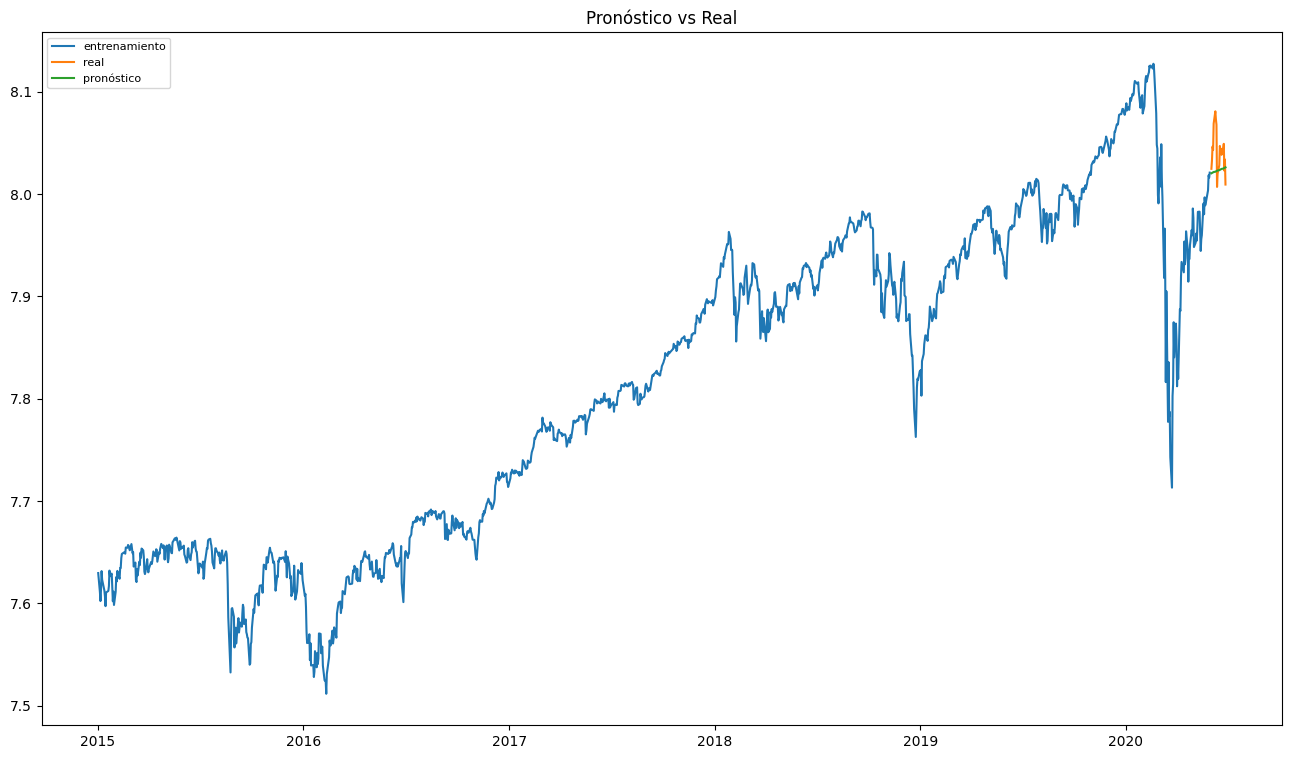

In [ ]:
# Construir el modelo SARIMA con parámetros especificados
modelo = SARIMAX(entrenamiento,
                 order=(1, 0, 1),                 # Parámetros no estacionales: (p=1, d=0, q=1)
                 seasonal_order=(0, 0, 0, 12),    # Parámetros estacionales: (P=0, D=0, Q=0, s=12)
                 enforce_stationarity=False,     # No se fuerza la estacionariedad
                 enforce_invertibility=False)    # No se fuerza la invertibilidad

# Ajustar el modelo a los datos de entrenamiento
modelo_ajustado = modelo.fit()  # Se eliminó 'disp=-1' porque no es válido en versiones recientes

# Generar pronóstico a 20 pasos hacia adelante
pronostico = modelo_ajustado.forecast(20)

# Convertir el pronóstico a una serie de pandas con el mismo índice del conjunto de prueba
serie_pronostico = pd.Series(pronostico.values, index=prueba.index[:20])

# Graficar datos de entrenamiento, prueba y pronóstico
plt.figure(figsize=(16, 9))
plt.plot(entrenamiento, label='entrenamiento')        # Serie histórica usada para entrenar
plt.plot(prueba, label='real')                        # Datos reales (conjunto de prueba)
plt.plot(serie_pronostico, label='pronóstico')        # Valores pronosticados por el modelo
plt.title('Pronóstico vs Real')                       # Título del gráfico
plt.legend(loc='upper left', fontsize=8)              # Leyenda en la parte superior izquierda


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x1bd90882630>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x1bd8a9984a0>)

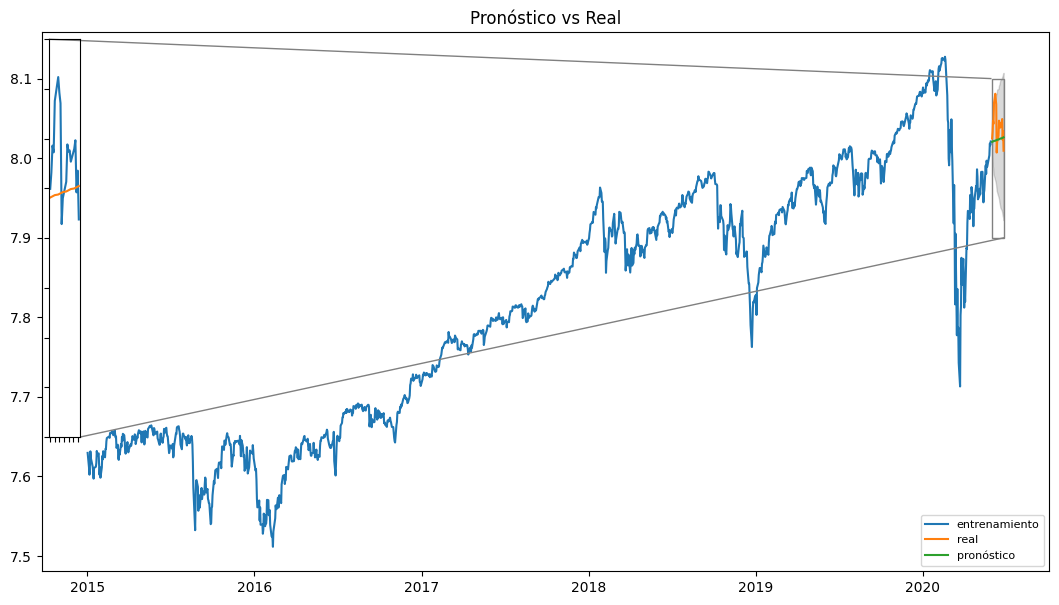

In [ ]:
# Crear figura y eje principal para graficar
fig, ax = plt.subplots()

# Graficar la serie de entrenamiento
ax.plot(entrenamiento, label='entrenamiento')

# Graficar la serie real (datos de prueba)
ax.plot(prueba, label='real')

# Graficar la serie de pronóstico
ax.plot(serie_pronostico, label='pronóstico')

# Agregar el intervalo de confianza alrededor del pronóstico
ax.fill_between(serie_inferior.index, serie_inferior, serie_superior, 
                color='k', alpha=.15)

# Establecer el título del gráfico
ax.set_title('Pronóstico vs Real')

# Agregar leyenda en la parte inferior derecha
ax.legend(loc='lower right', fontsize=8)

# Crear un subgráfico con zoom (factor 2.5) ubicado en la esquina superior izquierda del eje principal
axins = zoomed_inset_axes(ax, 2.5, loc=2)

# Graficar la serie real en la ventana de zoom
axins.plot(prueba)

# Graficar la serie de pronóstico en la ventana de zoom
axins.plot(serie_pronostico)

# Definir los límites del eje x e y para el área con zoom
x1, x2, y1, y2 = 2550, 2620, 7.9, 8.1

# Aplicar los límites al eje y (el límite en x está comentado)
axins.set_ylim(y1, y2)

# Ocultar etiquetas del eje y en la ventana de zoom
plt.yticks(visible=False)

# Ocultar etiquetas del eje x en la ventana de zoom
plt.xticks(visible=False)

# Dibujar líneas que conectan el gráfico principal con la región ampliada
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


In [ ]:
# Definir la función para calcular el error porcentual absoluto medio (MAPE)
def error_porcentual_absoluto_medio(y_real, y_predicho): 
    y_real, y_predicho = np.array(y_real), np.array(y_predicho)
    return np.mean(np.abs((y_real - y_predicho) / y_real)) * 100

# Imprimir el error cuadrático medio (MSE) del modelo SARIMAX
print('Error cuadrático medio del modelo SARIMAX:', mean_squared_error(np.exp(prueba), np.exp(serie_pronostico)))

# Imprimir el error absoluto medio (MAE) del modelo SARIMAX
print('Error absoluto medio del modelo SARIMAX:', mean_absolute_error(np.exp(prueba), np.exp(serie_pronostico)))

# Imprimir el error porcentual absoluto medio (MAPE) del modelo SARIMAX
print('Error porcentual absoluto medio del modelo SARIMAX:', error_porcentual_absoluto_medio(np.exp(prueba), np.exp(serie_pronostico)))


Error cuadrático medio del modelo SARIMAX: 7160.399849760412
Error absoluto medio del modelo SARIMAX: 67.834874054692
Error porcentual absoluto medio del modelo SARIMAX: 2.1557077179268314


### SSA

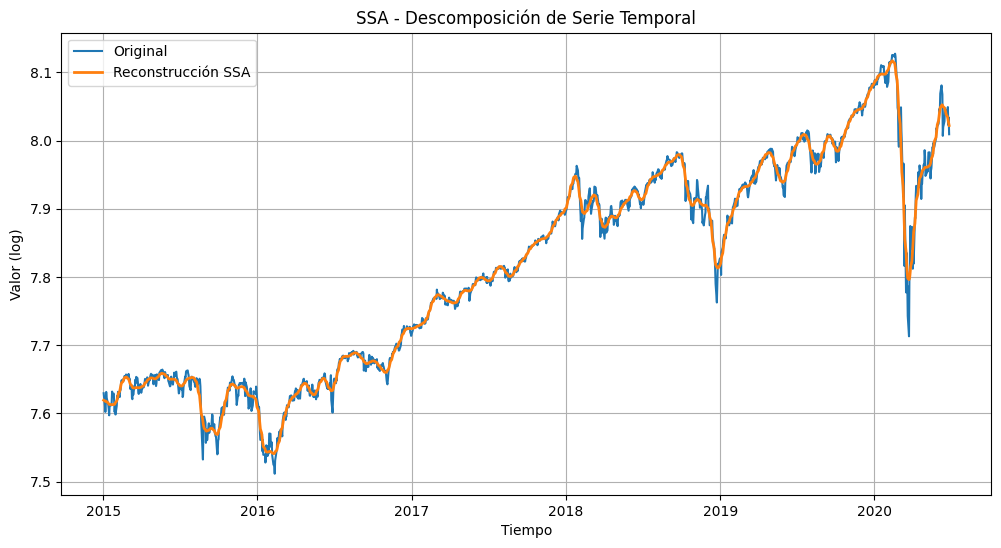

In [ ]:
# Convertir la columna a un array 2D (requisito de pyts)
serie = datos_periodo_seleccionado['y_log'].values.reshape(1, -1)

# Crear el modelo SSA
window_size = 30  # Puedes ajustar esto según la longitud de tu serie
ssa = SingularSpectrumAnalysis(window_size=window_size)

# Ajustar el modelo y obtener los componentes
components = ssa.fit_transform(serie)

# Reconstruir usando los primeros 2-3 componentes principales (tendencia y ciclos)
reconstructed = components[:, :3].sum(axis=1).ravel()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(datos_periodo_seleccionado.index, datos_periodo_seleccionado['y_log'], label='Original')
plt.plot(datos_periodo_seleccionado.index, reconstructed, label='Reconstrucción SSA', linewidth=2)
plt.title('SSA - Descomposición de Serie Temporal')
plt.xlabel('Tiempo')
plt.ylabel('Valor (log)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
INDICE_FIN_ENTRENAMIENTO = 1361

# Crear el conjunto de entrenamiento con los primeros 1361 registros (log-transformación de SP500)
entrenamiento = datos_periodo_seleccionado.y_log[:INDICE_FIN_ENTRENAMIENTO]

# Crear el conjunto de prueba con los datos restantes
prueba = datos_periodo_seleccionado.y_log[INDICE_FIN_ENTRENAMIENTO:]

# ----- SSA -----
# Tamaño de ventana de embedding (L): sugerencia, entre N/4 y N/2
L = 60  # Puedes ajustar este valor

# Ajustar SSA al entrenamiento
ssa = prs.ssa(entrenamiento, L=L)

# Seleccionar los primeros k componentes principales (puedes cambiar el número)
k = 5
groups = [list(range(1, k + 1))]

# Pronóstico de 20 pasos hacia adelante, con IC del 95%
fc = prs.forecast(
    ssa,
    groups=groups,
    length=20,
    method='recurrent',
    interval='confidence',
    level=0.95
)

# Crear series pandas para pronóstico y límites
serie_pronostico = pd.Series(fc.mean, index=prueba.index[:20])
serie_inferior   = pd.Series(fc.lower, index=prueba.index[:20])
serie_superior   = pd.Series(fc.upper, index=prueba.index[:20])

# Graficar resultados igual que con ARIMA
plt.figure(figsize=(16, 9))
plt.plot(entrenamiento, label='entrenamiento')
plt.plot(prueba, label='real')
plt.plot(serie_pronostico, label='pronóstico SSA')
plt.fill_between(serie_inferior.index, serie_inferior, serie_superior, color='k', alpha=.15)
plt.title('Pronóstico SSA vs Real')
plt.legend(loc='upper left', fontsize=8)
plt.show()

NameError: name 'prs' is not defined

In [ ]:
# y_true: serie original
y_true = datos_periodo_seleccionado['y_log'].values

# y_pred: reconstrucción SSA desde los componentes (ejemplo anterior)
y_pred = reconstructed  # Debe ser del mismo tamaño

# MSE - Error Cuadrático Medio
mse = mean_squared_error(y_true, y_pred)

# MAE - Error Absoluto Medio
mae = mean_absolute_error(y_true, y_pred)

# MAPE - Error Porcentual Absoluto Medio (con protección por ceros)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Mostrar resultados
print(f"Error cuadrático medio del modelo SSA: {mse:.4f}")
print(f"Error absoluto medio del modelo SSA: {mae:.4f}")
print(f"Error porcentual absoluto medio del modelo SSA: {mape:.2f}%")



Error cuadrático medio del modelo SSA: 0.0001
Error absoluto medio del modelo SSA: 0.0068
Error porcentual absoluto medio del modelo SSA: 0.09%


### LSTM

In [ ]:
# Crear un objeto escalador de tipo MinMaxScaler para normalizar los datos entre 0 y 1
scaler = MinMaxScaler()

# Obtener los valores de la serie SP500 y redimensionarlos en una matriz columna
valores_escalados = datos_periodo_seleccionado.SP500.values.reshape(datos_periodo_seleccionado.SP500.shape[0], 1)

# Aplicar la transformación de escalado a los datos
valores_escalados = scaler.fit_transform(valores_escalados)

# Definir una función para preparar los datos en secuencias para modelos basados en ventanas temporales (ej. LSTM)
def preprocesar(datos, ventana):
    X, y = [], []
    # A partir de cada posición 'i', construir una secuencia con los 'ventana' valores anteriores
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, 0])  # Entrada: valores anteriores
        y.append(datos[i, 0])            # Salida: valor actual
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana deslizante (número de pasos temporales)
ventana = 60

# Aplicar la función de preprocesamiento a los datos escalados
X, y = preprocesar(valores_escalados, ventana)

# Dividir los datos en conjuntos de entrenamiento (90%) y prueba (10%)
X_entrenamiento, X_prueba = X[:int(X.shape[0]*0.90)], X[int(X.shape[0]*0.90):]
y_entrenamiento, y_prueba = y[:int(y.shape[0]*0.90)], y[int(y.shape[0]*0.90):]

# Imprimir el número de observaciones en cada conjunto
print(X_entrenamiento.shape[0])
print(X_prueba.shape[0])
print(y_entrenamiento.shape[0])
print(y_prueba.shape[0])

# Construcción del modelo secuencial LSTM con Keras
modelo1 = Sequential()
modelo1.add(LSTM(64, input_shape=(X_entrenamiento.shape[1], 1)))  # Capa LSTM con 64 unidades
modelo1.add(Dense(1))                                             # Capa densa de salida con una sola neurona
modelo1.compile(optimizer='adam', loss='mse')                     # Compilar el modelo con optimizador Adam y pérdida MSE

# Mostrar un resumen de la arquitectura del modelo
modelo1.summary()


1188
133
1188
133


C:\Users\fperilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Redimensionar los datos de entrada para que cumplan con el formato requerido por LSTM: (muestras, pasos de tiempo, características)
X_entrenamiento = X_entrenamiento.reshape((X_entrenamiento.shape[0], X_entrenamiento.shape[1], 1))
X_prueba = X_prueba.reshape((X_prueba.shape[0], X_prueba.shape[1], 1))

# Entrenar el modelo con los datos de entrenamiento durante 40 épocas
# Se utiliza también el conjunto de prueba como validación para monitorear sobreajuste
# shuffle=False asegura que las secuencias temporales se mantengan en orden
historial1 = modelo1.fit(X_entrenamiento, y_entrenamiento, 
                         epochs=40, 
                         validation_data=(X_prueba, y_prueba), 
                         shuffle=False)


Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0113 - val_loss: 0.0161
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0103 - val_loss: 0.0125
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.6837e-04 - val_loss: 0.0078
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.6889e-04 - val_loss: 0.0078
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.7451e-04 - val_loss: 0.0078
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.9764e-04 - val_loss: 0.0072
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0021e-04 - val_loss: 0.0069
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.7144e-04 - val_loss: 0.0067
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.8904e-04 - val_loss: 0.0064
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.8878e-04 - val_loss: 0.0062
Epoch 12/40
38/38 ━━━━━━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


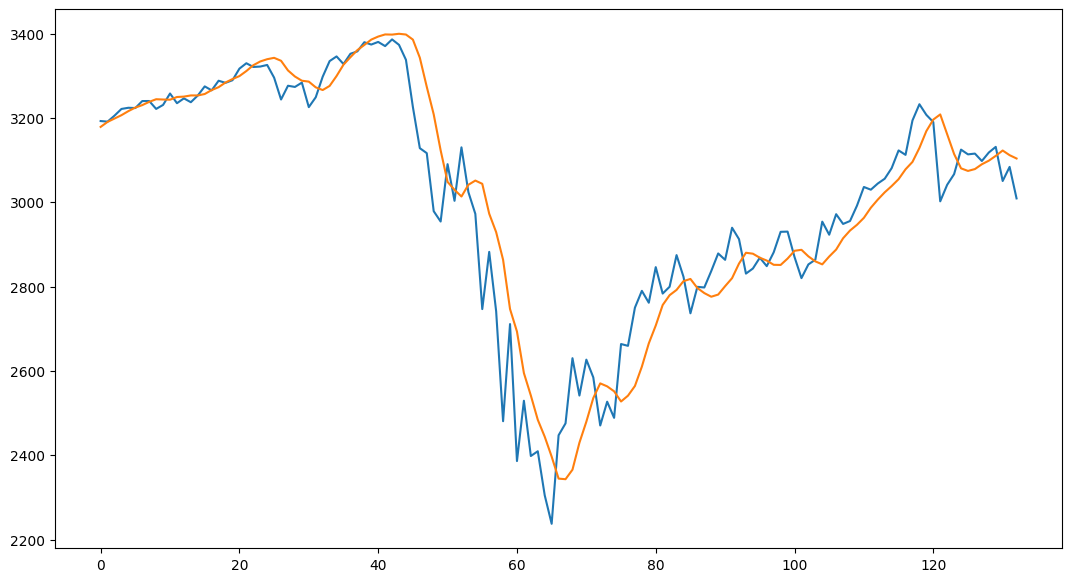

In [ ]:
# Generar predicciones del modelo LSTM utilizando el conjunto de prueba
predicciones = modelo1.predict(X_prueba)

# Graficar los valores reales reescalados a su escala original (inversa de MinMaxScaler)
plt.plot(scaler.inverse_transform(y_prueba.reshape(-1, 1)))

# Graficar las predicciones también reescaladas a su escala original
plt.plot(scaler.inverse_transform(predicciones))


In [ ]:
# Inicializar listas para almacenar los valores reales y pronosticados
act = []
pred = []

# Iterar sobre cada muestra del conjunto de prueba
for i in range(X_prueba.shape[0]):
    # Realizar predicción para una muestra individual redimensionada a (1, 60, 1)
    Xt = modelo1.predict(X_prueba[i].reshape(1, 60, 1))
    
    # Reescalar la predicción a su escala original y agregarla a la lista de predicciones
    pred.append(scaler.inverse_transform(Xt))
    
    # Reescalar el valor real a su escala original y agregarlo a la lista de valores reales
    act.append(scaler.inverse_transform(y_prueba[i].reshape(-1, 1)))

# Crear un DataFrame con los resultados: valores pronosticados y reales
resultado_df = pd.DataFrame({
    'pronosticado': list(np.reshape(pred, (-1))),
    'real': list(np.reshape(act, (-1)))
})

# Mostrar las primeras filas del DataFrame de resultados
resultado_df.head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

,pronosticado,real
0,3178.635986,3192.52
1,3190.509521,3191.14
2,3198.442871,3205.37
3,3206.443604,3221.22
4,3216.084229,3224.01


In [ ]:
# Definir función para calcular el error porcentual absoluto medio (MAPE)
def error_porcentual_absoluto_medio(y_real, y_predicho):
    y_real, y_predicho = np.array(y_real), np.array(y_predicho)
    return np.mean(np.abs((y_real - y_predicho) / y_real)) * 100

# Asignar la columna de valores reales del DataFrame a la variable 'test'
test = resultado_df['real']

# Asignar la columna de valores pronosticados del DataFrame a la variable 'forecast'
forecast = resultado_df['pronosticado']

# Calcular y mostrar el error cuadrático medio (MSE) del modelo LSTM
print('Error cuadrático medio del modelo LSTM:', mean_squared_error(test, forecast))

# Calcular y mostrar el error absoluto medio (MAE) del modelo LSTM
print('Error absoluto medio del modelo LSTM:', mean_absolute_error(test, forecast))

# Calcular y mostrar el error porcentual absoluto medio (MAPE) del modelo LSTM
print('Error porcentual absoluto medio del modelo LSTM:', error_porcentual_absoluto_medio(test, forecast))



Error cuadrático medio del modelo LSTM: 8812.319817709771
Error absoluto medio del modelo LSTM: 63.6163063175517
Error porcentual absoluto medio del modelo LSTM: 2.2579306396765215


In [4]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mlflow.set_experiment("sp500_forecast")

with mlflow.start_run():
    mlflow.log_param("coef_0", modelo1.coef_[0])
    mlflow.log_param("intercept", modelo1.intercept_)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.sklearn.log_model(modelo1, artifact_path="model")

    # Gráfica
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(y_test.values, label="Real", color='blue')
    ax.plot(y_pred, label="Predicción", color='orange')
    ax.set_title("Predicción vs Real")
    ax.legend()
    plt.tight_layout()
    fig.savefig("pred_vs_real.png")
    mlflow.log_artifact("pred_vs_real.png")

NameError: name 'modelo1' is not defined